So far, we primarily looked at regression. Sometimes, you need to classify, i.e. predict which class/category a particular data belongs to. In this case, you deal with categorical labels, not continous labels. For instance, is a material high or low bandgap? 

In this notebook, we will look at maximum margin classifiers and support vector classifiers and talk a little bit about support vector machines as an example nonlinear method. 

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("binary_band_gap.csv")

df.head()

,Formula,Eg (eV)
0,AgAu3,0.00
1,BaAg2,0.00
2,AgBr,2.52
3,CdAg,0.00
4,AgCl,5.13


In [3]:
pip install pymatgen

Note: you may need to restart the kernel to use updated packages.


In [5]:
from pymatgen.core import Element, Composition

df["composition"] = [Composition(c) for c in df["Formula"]]
df.head()

,Formula,Eg (eV),composition
0,AgAu3,0.00,"(Ag, Au)"
1,BaAg2,0.00,"(Ba, Ag)"
2,AgBr,2.52,"(Ag, Br)"
3,CdAg,0.00,"(Cd, Ag)"
4,AgCl,5.13,"(Ag, Cl)"


In [30]:
def classify(eg):
    if eg < 0.01:
        return -1
    else:
        return 1
    
df["class"] = [classify(eg) for eg in df["Eg (eV)"]]

Y = df["class"]

EN = [[el.X for el in c] for c in df["composition"]]


X = np.array(EN)

Text(0, 0.5, 'EN-2')

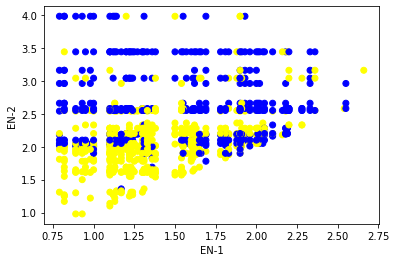

In [33]:
colors = np.where(Y==1, "blue", "yellow")



import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], color=colors)
plt.xlabel("EN-1")
plt.ylabel("EN-2")

In general, to get a model that correctly predicts which class a particular data point belongs to, we should have a line (or a hyperplane in general) and depending on which side of that line (or hyperplane) that point falls, we can say which class it belongs to. See figure below...


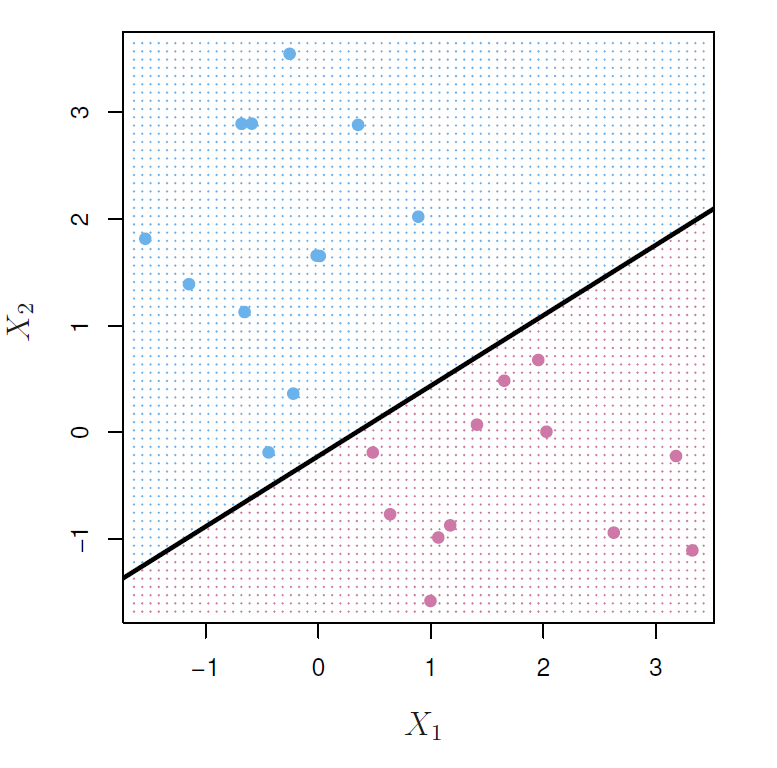

Here, any point below the line belongs in one category, and any point above this line belongs to another category. This of course is a simplified case where you have two categories and two descriptors. In general, there can be p descriptors and m classes. 

In this case, the hyperplane is a line... say of the form: $\beta_0 + \beta_1x_1 + \beta_2x_2 = 0$... So a point ($x_1^*, x_2^*$) belongs to one category or the other depending on the value of $\beta_0 + \beta_1x_1^*+\beta_2x_2^*$ (i.e. if it is greater than zero, it belongs to one class, and if less than zero, it belongs to the other)... 

However, many such lines can potentially be drawn based on your training data... 

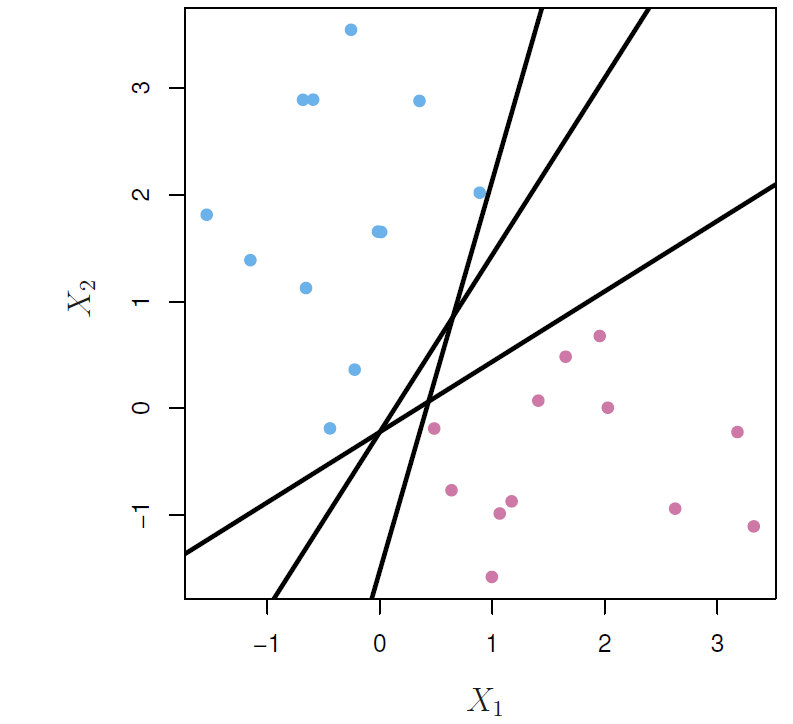

So, how do we pick the "best" one? 

A natural choice is the maximal margin hyperplane (also known as the optimal separating hyperplane), which is the separating hyperplane that is farthest from the training observations. That is, we can compute the (perpendicular) distance from each training observation to a given separating hyperplane; the smallest such distance is the minimal distance from the observations to the hyperplane, and is known as the margin.

We can then classify a test observation based on which side of the maximal margin hyperplane it lies. This is known as the maximal margin classifier.

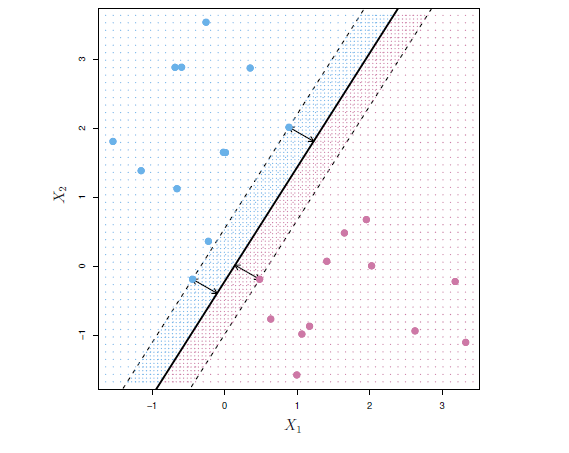

We see that three training observations are equidistant from the maximal margin hyperplane and lie along the dashed lines indicating the width of the margin. These three observations are known as support vectors, since they are vectors in p-dimensional descriptor space  and they “support” the maximal margin hyperplane in the sense vector that if these points were moved slightly then the maximal margin hyperplane would move as well.

The problem that needs to be solved to get this clasifier is: 

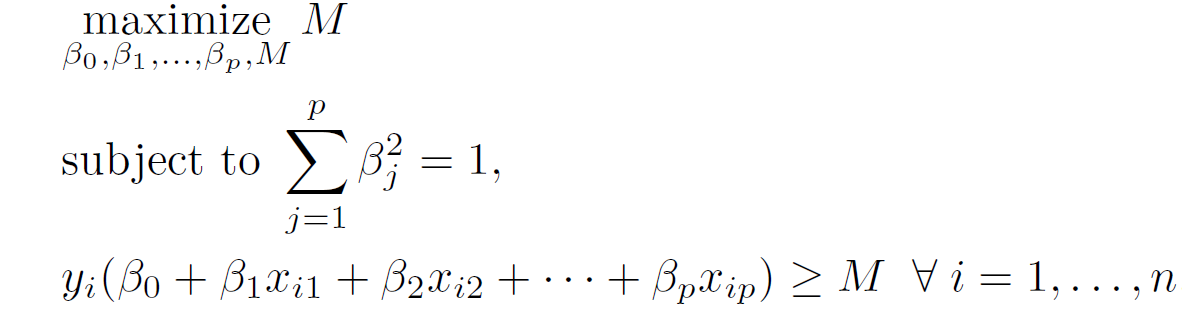

Note that this is a simplistic scenario. In general, (1) the data may not be so easily classifiable (see our case above) so you need to tolerate some missclassification, (2) you want the model to not be too dependent on the support vectors (allowing some tolerance to missclassification will fix this too), (3) the decision boundary may not be linear (you need nonlinear kernels to compare data points)... Here's where you use support vector machines.. 

The formulation is as shown in https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train,  Y_test = train_test_split(
    X, Y, test_size=0.1)

In [46]:
from sklearn import svm

model = svm.SVC(kernel='linear', C=1)
model.fit(X_train, Y_train)

SVC(C=1, kernel='linear')

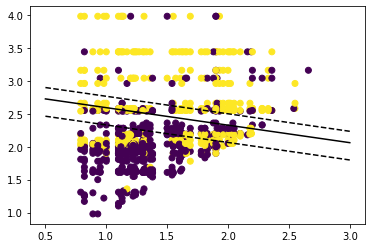

In [47]:
# get the separating hyperplane -- see https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_separating_hyperplane.html
w = model.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(0.5, 3)
yy = a * xx - (model.intercept_[0]) / w[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors
b = model.support_vectors_[0]
yy_down = a * xx + (b[1] - a * b[0])
b = model.support_vectors_[-1]
yy_up = a * xx + (b[1] - a * b[0])

# plot the line, the points, and the nearest vectors to the plane

plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(model.support_vectors_[:, 0],model.support_vectors_[:, 1],
           s=80, facecolors='none')
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)

Accuracy:  64.44444444444444 %


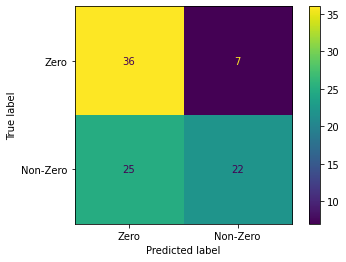

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, Y_test, values_format = 'd', display_labels=["Zero", "Non-Zero"])

confusion_matrix = pd.crosstab(Y_test, model.predict(X_test))
TN = confusion_matrix.iloc[0,0]
FN = confusion_matrix.iloc[1,0]
TP = confusion_matrix.iloc[1,1]
FP = confusion_matrix.iloc[0,1]

accuracy = (TP+TN)/(TP+TN+FP+FN)
print("Accuracy: ", accuracy*100, "%")

In [50]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(Y_test, model.predict(X_test)))

Accuracy: 0.6444444444444445


Note that the model is slightly better than a naive prediction. If the model said "non zero" for all cases, its accuracy would have been (25 + 22)/(36 + 7 + 25 + 22) = 52%

There are different kernel functions... See https://scikit-learn.org/stable/modules/svm.html#svm-kernels

In [51]:
model = svm.SVC(kernel='poly', degree=2)
model.fit(X_train, Y_train)

print("Accuracy:",metrics.accuracy_score(Y_test, model.predict(X_test)))

Accuracy: 0.7111111111111111


In [62]:
model = svm.SVC(kernel='rbf', gamma=100, C=1000)
model.fit(X_train, Y_train)

print("Accuracy:",metrics.accuracy_score(Y_test, model.predict(X_test)))

Accuracy: 0.7444444444444445


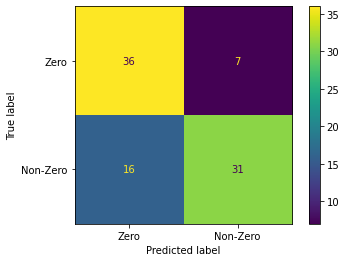

In [63]:
plot_confusion_matrix(model, X_test, Y_test, values_format = 'd', display_labels=["Zero", "Non-Zero"])
